# Age and Gender Prediction

### Dataset: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv

### Tensorflow – Developed by Google, this open-source library is used for creating Deep learning models. It provides many methods to interpret data but mainly focuses on training and inference of Neural Networks

In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import pandas as pd
import numpy as np

# Reading the Dataset
The dataset used here was in a csv format. We used Pandas to read the csv file and print the shape and information about the dataset.

In [3]:
# reading the dataset
df= pd.read_csv('age_gender.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


# EDA

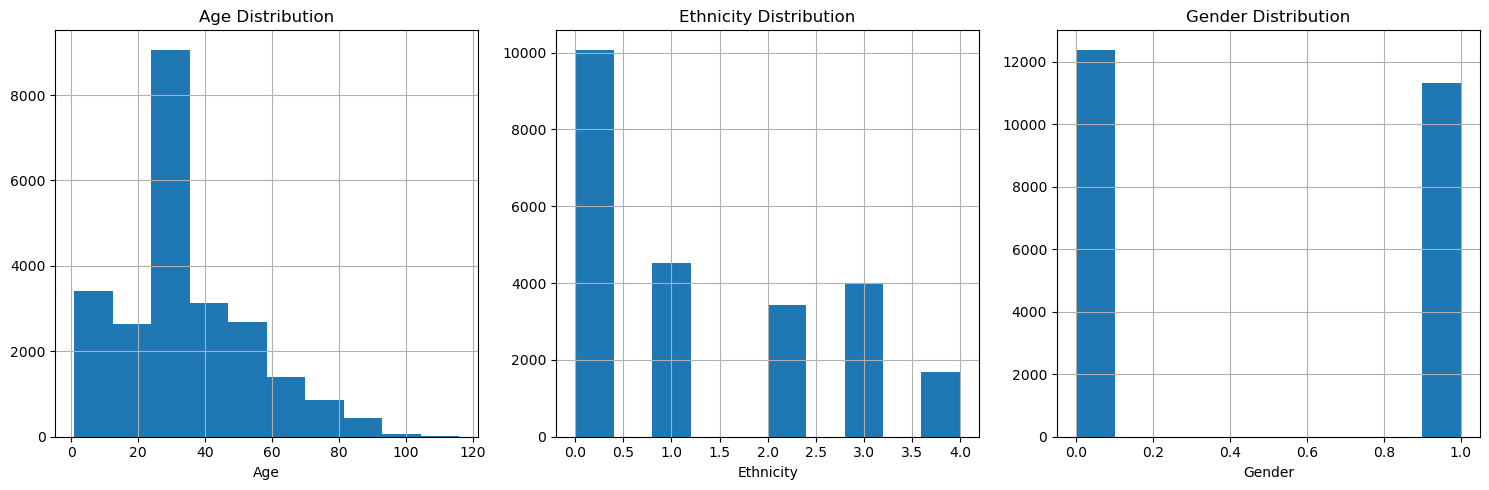

In [5]:
# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
df['age'].hist(ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')

df['ethnicity'].hist(ax=axes[1])
axes[1].set_title('Ethnicity Distribution')
axes[1].set_xlabel('Ethnicity')

df['gender'].hist(ax=axes[2])
axes[2].set_title('Gender Distribution')
axes[2].set_xlabel('Gender')

plt.tight_layout()
plt.show()

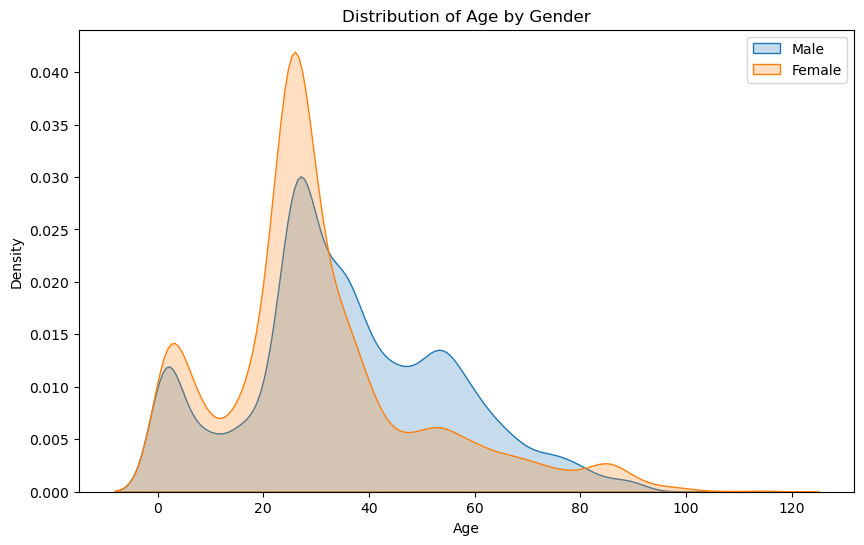

In [6]:
import seaborn as sns

# Filter data for male and female separately
male_data = df[df['gender'] == 0]
female_data = df[df['gender'] == 1]

# Plot the distributions of age for male and female
plt.figure(figsize=(10, 6))
sns.kdeplot(data=male_data['age'], label='Male', fill=True)
sns.kdeplot(data=female_data['age'], label='Female', fill=True)
plt.title('Distribution of Age by Gender')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

# Feature Engineering & Transformations
We are concerned about the pixels column in the dataframe. But the values in that column are an object type data type. To convert the datatype of the column, we will define a function which adheres to our purpose at hand and then apply it to create a new column.

In [7]:
# creating a fuctio which will change the datatype to an array
def str_to_array(ob):
	return np.array(ob.split(' '), dtype='int')

# apply the function to pixels column and create a new column 'new_pixels'
df['new_pixels'] = df['pixels'].apply(str_to_array)

In [8]:
df.head()

,age,ethnicity,gender,img_name,pixels,new_pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,"[129, 128, 128, 126, 127, 130, 133, 135, 139, ..."
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,"[164, 74, 111, 168, 169, 171, 175, 182, 184, 1..."
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,"[67, 70, 71, 70, 69, 67, 70, 79, 90, 103, 116,..."
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,"[193, 197, 198, 200, 199, 200, 202, 203, 204, ..."
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,"[202, 205, 209, 210, 209, 209, 210, 211, 212, ..."


In [9]:
len(df['new_pixels'][0])

2304

In [10]:
df.shape

(23705, 6)

# Check the input Face images - the given data
To visualize an Image, we are first generating a list of random indices value from the dataset and using that to plot a subplot of images. To plot the image we have to first reshape the data into a (48,48,1) shape.

[17404, 6238, 1609, 16699, 16989, 20656, 111, 3298, 17042, 6389, 10517, 14881, 935, 1517, 11373]


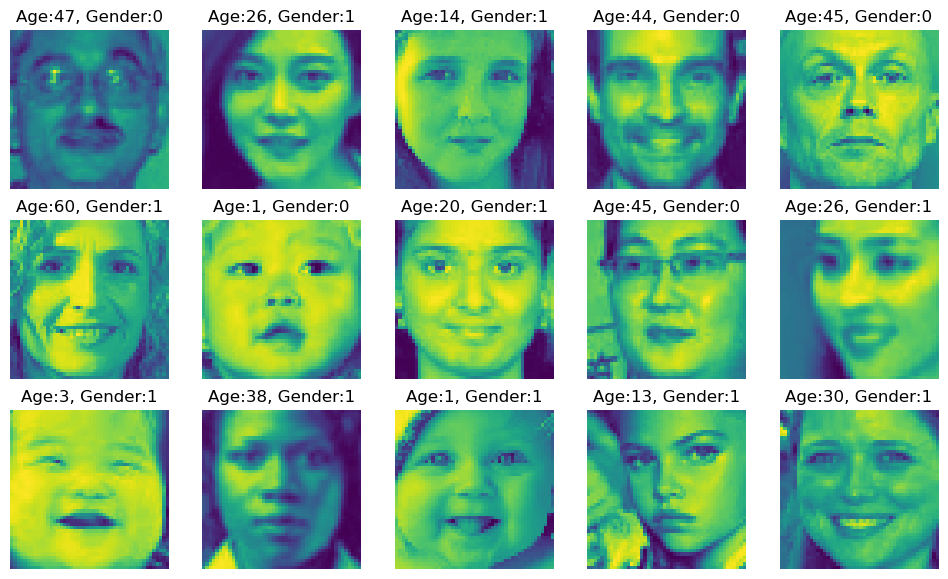

In [11]:
# creating an empty 3x5 subplot
fig, ax = plt.subplots(3, 5, figsize=(12, 7))
ax = ax.ravel()

# generating a random list of integers
res = random.sample(range(0, df.shape[0]), 15)

print (res)

# creating the subplot for random images and printing the corresponding gender and age
for i, id in enumerate(res):
	ax[i].imshow(df['new_pixels'].loc[id].reshape(48, 48))
	ax[i].set_title(f'Age:{df.age.loc[id]}, Gender:{df.gender.loc[id]}')
	ax[i].axis('off')

plt.savefig('image_visualization_subplot.png')

# Model Building
To start with creating the model, we first expand the new pixels column to make a dataframe. Using that dataframe and necessary target values (age and gender), we will split our dataset into training and Validation Dataset.

In [12]:
# Create the X (predictor) variables
X_new = pd.DataFrame(df['new_pixels'].tolist())

# Assign Predictor Variables and Target variables
X = X_new
y_age = df['age'].values
y_gender = df['gender'].values

# split the Variables into Train and Validation sets
y_reg_train, y_reg_val, y_clf_train, y_clf_val, X_train, X_val = train_test_split(y_age,
																				y_gender,
																				X,
																				test_size=0.2,
																				stratify = y_gender,
																				random_state=42)
# Check the shape
y_reg_train.shape, y_reg_val.shape, y_clf_train.shape, y_clf_val.shape, X_train.shape, X_val.shape

((18964,), (4741,), (18964,), (4741,), (18964, 2304), (4741, 2304))

# Normalizations
Before we proceed forward, a necessary step in Data preparation for training is to normalize the pixel data. This ensures that the pixels are in a similar data distribution which will help in faster model convergence in training.

In [13]:
np.array(df['new_pixels'].tolist()).min()

0

In [14]:
np.array(df['new_pixels'].tolist()).max()

255

In [15]:
type(X_train)

pandas.core.frame.DataFrame

In [16]:
type(X_val)

pandas.core.frame.DataFrame

In [17]:
# Normalising the Pixel data for training dataset and then reshaping it to (48,48,1) 
Xmin = 0
Xmax = 255
X_train = X_train.values
# This line normalizes the pixel values. Each pixel value is subtracted by the minimum value (Xmin) and divided by the range of pixel values (Xmax - Xmin). 
# This brings the pixel values to the range [0, 1].
X_train = (X_train - Xmin)/(Xmax-Xmin) 
# This reshapes the normalized X_train array into a 4D array, where each image is represented as a 3D array with dimensions (48, 48, 1). 
# The -1 in the reshape function means that the size of that dimension is inferred from the size of the original array, preserving the number of images. 
# The (48, 48, 1) indicates that each image has a height and width of 48 pixels and a depth of 1 (for grayscale images).
X_train = X_train.reshape(-1,48,48,1)


# similar step is taken for Validation set
X_val = X_val.values
X_val = (X_val - Xmin)/(Xmax-Xmin)
X_val = X_val.reshape(-1,48,48,1)

In [18]:
X_train.shape

# 48*48 = 2304

(18964, 48, 48, 1)

In [19]:
# X_train

# Creating The CNN model Arch

The model architecture is made using functional API of keras. This method is helpful in **joining two types of output (in this case regression and classification) as a single output** to be fed to the model.

The Model takes 3 parts:



Input: This layer takes in the input data with shape (48,48,1)

Middle architecture: All the Deep Learning Networks are cascaded over Input layer, i.e., the input layer is joined with subsequent layers in the deep learning model. In this case the architecture consists of:

a single Conv2D layer with 16 node

a single Conv2D layer with 32 nodes followed by Maxpooling2D layer

two conv2D layer with 64 nodes each

a flatten layer

two dense layer of 128 and 32 nodes respectively



Output: The output of the model consist of two dense layers which corresponds to the necessary task they will perform which are:

a dense layer with 1 node and sigmoid activation which will perform the **gender classification**

a dense layer with 1 node and linear activation which will perform the **age regression prediction**



For all the other layers, necessary activations were provided. To understand the underlying layers and the parameters involved in the model architecture created above, we will plot the model

In [21]:
from tensorflow.keras.layers import Dropout  # Import Dropout from keras.layers

input_layer = keras.Input(shape=(48, 48, 1), name="Input image")

# 16: Specifies the number of filters (or output channels) in the convolutional layer. Each filter learns different features from the input.
# 3: Specifies the size of the convolutional kernel (filter) to be applied. In this case, it's a 3x3 kernel.
# activation="relu": Specifies the activation function to be applied after the convolution operation. In this case, it's the Rectified Linear Unit (ReLU) activation function, which introduces non-linearity to the network.
x = layers.Conv2D(16, 3, activation="relu")(input_layer)

x = layers.Conv2D(32, 3, activation="relu")(x)

# MaxPooling2D layer with pool size 3x3.
x = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu')(x)
# Adding dropout layer with 0.5 dropout rate
x = Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
# Adding dropout layer with 0.5 dropout rate
x = Dropout(0.5)(x)


out_a = keras.layers.Dense(1, activation='sigmoid', name='g_clf')(x)
out_b = keras.layers.Dense(1, activation='linear', name='a_reg')(x)

model = keras.Model(inputs = input_layer, outputs = [out_a, out_b], name="age_gender_model")

In [22]:
model.summary()

Model: "age_gender_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input image (InputLayer)      │ (None, 48, 48, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 46, 46, 16)        │             160 │ Input image[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 44, 44, 32)        │           4,640 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 14, 14, 32)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 12, 12, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 10, 10, 64)        │          36,928 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 6400)              │               0 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │         819,328 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 32)                │           4,128 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 32)                │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ g_clf (Dense)                 │ (None, 1)                 │              33 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ a_reg (Dense)                 │ (None, 1)                 │              33 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 883,746 (3.37 MB)

 Trainable params: 883,746 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

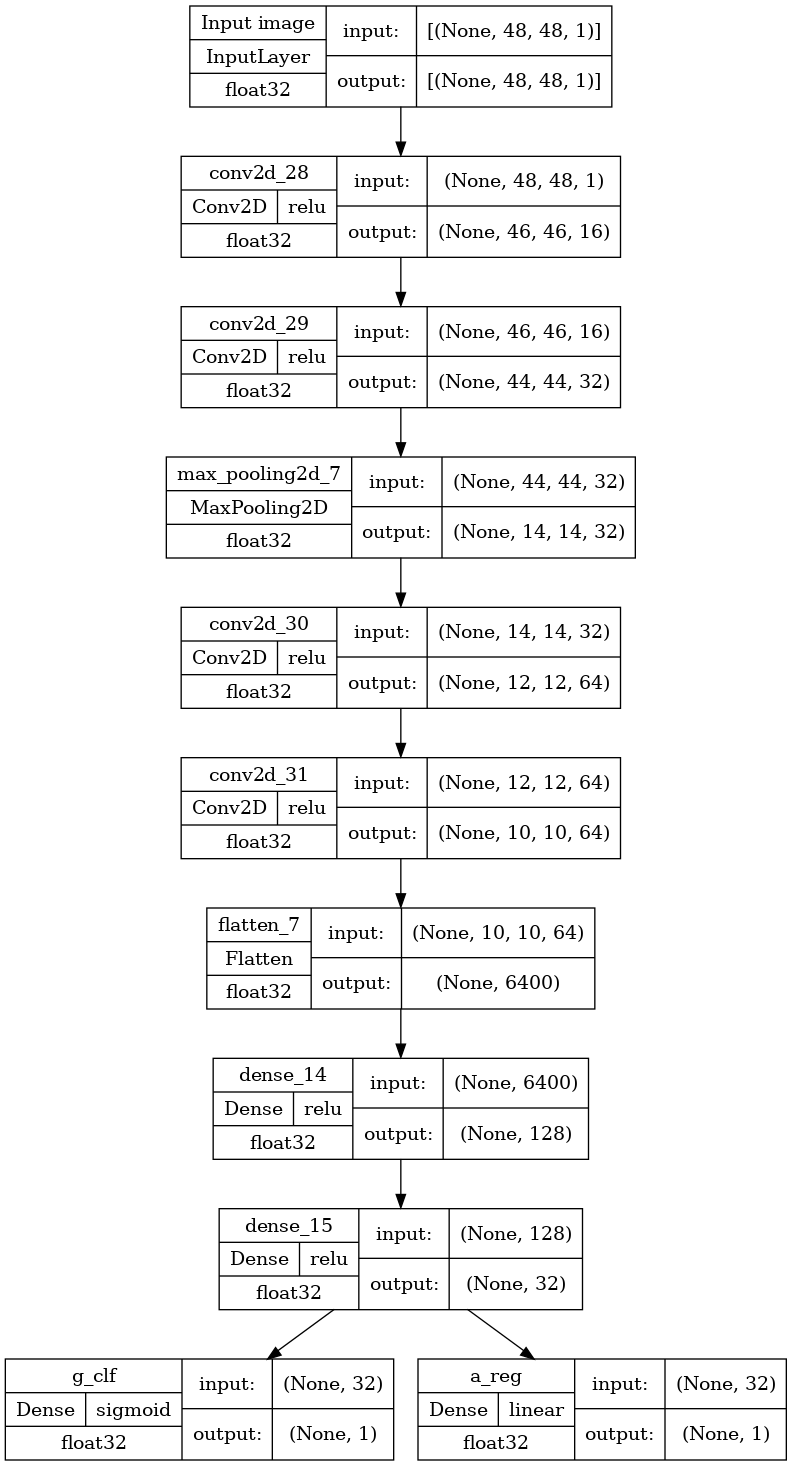

# Model Training
We compile the model with necessary loss, metrics and optimizers (for each output branch - g_clf and a_reg) and fitted the model for 200 epochs with an earlystopping of patience 25.

In [23]:
X_train.shape

(18964, 48, 48, 1)

In [24]:
y_clf_train.shape

(18964,)

In [25]:
y_reg_train.shape

(18964,)

Number of batches = Total number of data points / Batch size = 18964 / 256 =74


Since we can't have a fraction of a batch, typically, we would have 74 batches per epoch. The final batch might have fewer data points if the total number of data points is not an exact multiple of the batch size.

During each epoch, the model will iterate through these batches, updating the weights based on the gradients computed from each batch. This process repeats for the specified number of epochs until the model converges or reaches the maximum number of epochs.

---------------------------------------------
The model.fit() function trains the model using the data provided in the X_train and [y_clf_train, y_reg_train] parameters. The validation_data parameter is used to evaluate the model's performance on a separate validation dataset (X_val, [y_clf_val, y_reg_val]) after each epoch, but it doesn't train the model on this data.

So, your model is indeed trained on X_train and [y_clf_train, y_reg_train]. The validation_data is used solely for validation purposes during the training process to monitor the model's performance and prevent overfitting.

In [26]:
# compile the model
model.compile(
	loss = {
		"g_clf": 'binary_crossentropy',
		"a_reg": 'mse'
	},

	metrics = {
		"g_clf": 'accuracy',
		"a_reg": 'mse'
	},

	optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
)

# create an EarlyStopping instance which will stop if the val_loss doesn't change much in 25 epochs
callback = EarlyStopping(monitor='val_loss',
						patience=25,
						verbose=0)

# train the model 
history = model.fit(X_train, 
					[y_clf_train, y_reg_train],
					batch_size = 256, 
					validation_data= (X_val, [y_clf_val, y_reg_val]), 
					epochs=200, callbacks = [callback])

Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - a_reg_mse: 694.8578 - g_clf_accuracy: 0.4917 - loss: 697.1992 - val_a_reg_mse: 367.1356 - val_g_clf_accuracy: 0.5227 - val_loss: 367.8598
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - a_reg_mse: 484.5229 - g_clf_accuracy: 0.5094 - loss: 485.6014 - val_a_reg_mse: 578.0396 - val_g_clf_accuracy: 0.5227 - val_loss: 578.7249
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - a_reg_mse: 425.7161 - g_clf_accuracy: 0.5150 - loss: 426.4103 - val_a_reg_mse: 219.8161 - val_g_clf_accuracy: 0.5227 - val_loss: 220.4977
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - a_reg_mse: 311.8245 - g_clf_accuracy: 0.5334 - loss: 312.5065 - val_a_reg_mse: 179.0762 - val_g_clf_accuracy: 0.5387 - val_loss: 179.7466
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - a_reg_mse: 278.3776 - g_clf_accuracy: 0.5638 - loss: 279.0552 - val_a_reg_mse: 192.1553 - val_g_clf_accuracy: 0.5288 - val_loss: 192.8340
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━

# Plotting the Losses and Accuracy for Regression and Classification Respectively
To visualize the losses, we will use history of our model training and plot the necessary metrices.

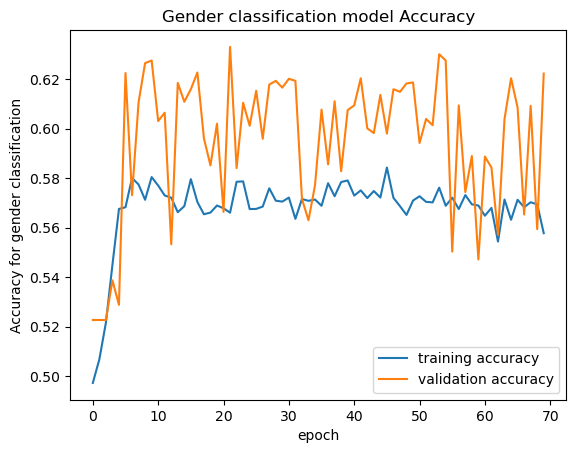

In [27]:
# plotting for Gender Classification Accuracy
plt.plot(history.history['g_clf_accuracy'], label = 'training accuracy')
plt.plot(history.history['val_g_clf_accuracy'], label = 'validation accuracy')
plt.title('Gender classification model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy for gender classification')
plt.legend()
plt.show()

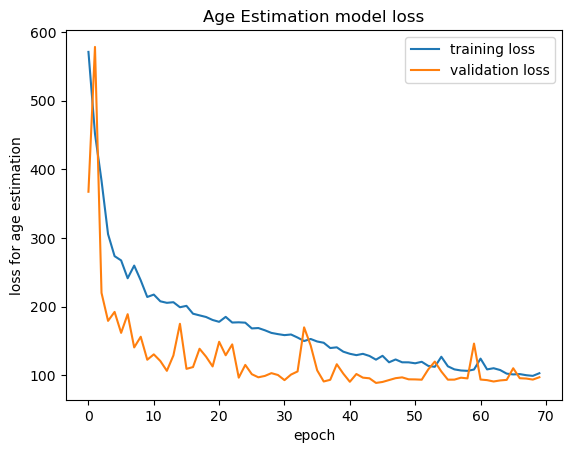

In [28]:
# plotting the mse loss for age regression 
plt.plot(history.history['a_reg_mse'], label = 'training loss')
plt.plot(history.history['val_a_reg_mse'], label = 'validation loss')
plt.title('Age Estimation model loss')
plt.xlabel('epoch')
plt.ylabel('loss for age estimation')
plt.legend()

plt.show()

# Model Evaluations

In [29]:
# valuate the model's performance on the validation dataset
model.evaluate(X_val, [y_clf_val, y_reg_val])

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - a_reg_mse: 100.6960 - g_clf_accuracy: 0.6161 - loss: 101.3684


[97.64787292480469, 96.9757080078125, 0.6222316026687622]

# Based on results above, val_loss: 221.9182 >> loss: 19.9258, it appears that the model may be overfitting the training data. 

In [30]:
X_val.shape

(4741, 48, 48, 1)

# Predict Age & Gender from the model - the results are good
We created a subplot of 3×3 with random indices and predicted the age and gender for the given input image

**The title at the top signifies actual age and gender whereas the title below signifies predicted age and gender.**

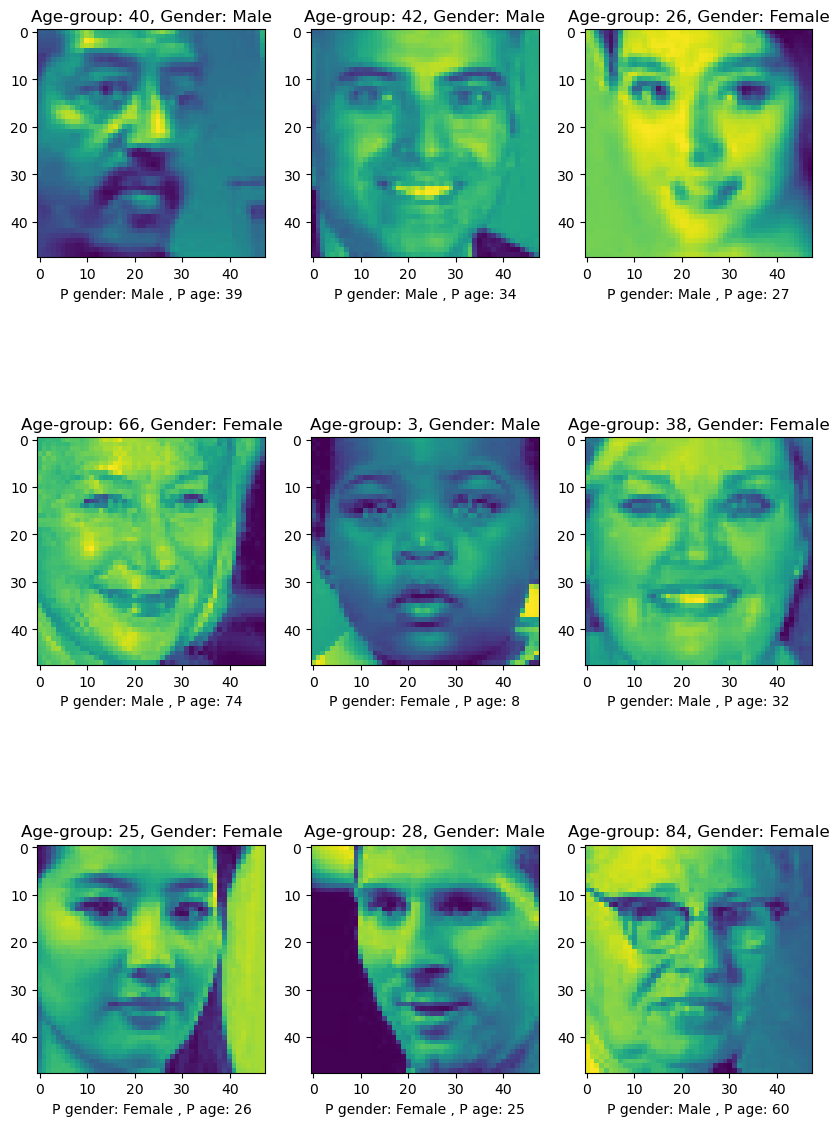

In [31]:
# Define the gender dictionary
gender_dict = {"0": "Male", "1": "Female"}

fig, ax = plt.subplots(3,3, figsize = (10,15))

ax = ax.ravel()

res = random.sample(range(0, X_val.shape[0]), 9)

for i,id in enumerate(res):
	ax[i].imshow(X_val[id])
	ax[i].set_title(f'Age-group: {y_reg_val[id]}, Gender: {gender_dict[str(y_clf_val[id])]}')
	
	pred_Gender, pred_age = model.predict(tf.expand_dims(X_val[id], 0), verbose = 0)
	y_value = np.where(pred_Gender > 0.5, 1,0)
    #  This function call returns an array where elements that satisfy the condition (i.e., where pred_Gender > 0.5) are replaced with 1, and elements that do not satisfy the condition are replaced with 0.
	ax[i].set_xlabel(f'P gender: {gender_dict[str(y_value[0][0])]} , P age: {int(np.round(pred_age,0))}')
	
plt.savefig('prediction_subplot.png')

In [32]:
X_val[2].shape

(48, 48, 1)